In [1]:
# standard python utilities
import os
from os.path import basename, dirname, join, exists
import sys
from importlib import reload
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# standard geospatial python utilities
# import pyproj # for converting proj4string
# import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator

# import flopy
# import flopy.utils.binaryfile as bf
from importlib import reload


In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)

git_dir = join(doc_dir, 'GitHub')
## Set up directory referencing
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'

bas_dir = join(gwfm_dir, 'BAS6')
proj_dir = join(gwfm_dir,'Mapping')
plt_dir = join(proj_dir,'figures/')


In [3]:
def add_path(fxn_dir):
    """ Insert fxn directory into first position on path so local functions supercede the global"""
    if fxn_dir not in sys.path:
        sys.path.insert(0, fxn_dir)
# flopy github path - edited
add_path(doc_dir+'/GitHub/flopy')
import flopy 

# other functions
py_dir = join(doc_dir,'GitHub/CosumnesRiverRecharge/python_utilities')
add_path(py_dir)

# from mf_utility import get_layer_from_elev
# from map_cln import gdf_bnds, plt_cln
import map_obs_plt as mop
from map_obs_plt import plt_bc_hk, plot_head_simple, plot_dtw_simple
from map_cln import gdf_bnds

# reload(mop)

In [143]:
# run_dir = 'C://WRDAPP/GWFlowModel'
run_dir = 'F://WRDAPP/GWFlowModel'
loadpth = run_dir +'/Cosumnes/Regional/'

# model_nam = 'historical_simple_geology'
model_nam = 'historical_simple_geology_reconnection'


model_ws = loadpth+model_nam


In [145]:
load_only = ['DIS','BAS6','UPW','OC','SFR','LAK']
m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='mf-owhm', version='mfnwt',
                              load_only = load_only
                              )

if 'LPF' in m.get_package_list():
    gel_nam = 'LPF'
else:
    gel_nam = 'UPW'
gel = m.__getattr__(gel_nam)

In [146]:
# gel = flopy.modflow.ModflowUpw.load(join(model_ws, 'MF.upw'), model=m)

In [147]:
sfr_dir = gwfm_dir+'/SFR_data/'
# grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
# grid_sfr['Kz'] = m.sfr.reach_data.strhc1
m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
grid_p['easting'] = grid_p.geometry.centroid.x
grid_p['northing'] = grid_p.geometry.centroid.y

lak_grid_clip = gpd.read_file(gwfm_dir+'/Levee_setback/lak_grid_clip/lak_grid_clip.shp')


In [148]:
sfr = m.sfr
sfrdf = pd.DataFrame(sfr.reach_data)
grid_sfr = grid_p.set_index(['row','column']).loc[list(zip(sfrdf.i+1,sfrdf.j+1))].reset_index(drop=True)
grid_sfr = pd.concat((grid_sfr,sfrdf),axis=1)

In [8]:
# map_fxn_dir = doc_dir+'/GitHub/mapping/01_python_scripts'
# if map_fxn_dir not in sys.path:
#     sys.path.append(map_fxn_dir)
# # sys.path
# from basic_mapping import gdf_bnds, pnt_2_tup, lab_pnt, plt_cln

In [9]:
# from shapely.geometry import Polygon
# def gdf_bnds(df, ax, buf=1):
#     """ Take a geodataframe plus a buffer and set the axis limits, and return the bounding box"""
#     lim = df.geometry.unary_union.buffer(buf).bounds
#     bnds = Polygon([(lim[0],lim[1]), (lim[2],lim[1]), (lim[2],lim[3]),(lim[0],lim[3])])
#     bnds = gpd.GeoDataFrame([0], geometry = [bnds], crs = df.crs)
#     ax.set_xlim(lim[0], lim[2])
#     ax.set_ylim(lim[1], lim[3])
#     return(bnds)

# Head plots and contours

In [149]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()
cbc = model_ws+'/MF.cbc'

strt_date = pd.to_datetime(m.dis.start_datetime)
dates = strt_date+(np.asarray(times)-1).astype('timedelta64[D]')

dt_ref = pd.DataFrame(dates, columns=['dt'])
dt_ref['kstpkper'] = spd_stp


In [30]:
rech = m.rch.rech.array[:,0,:,:]
rech_avg = pd.Series(rech.mean(axis=(1,2)))[1:]
# rech_avg.index=dt_ref.dt[:-1]

In [12]:
# convert pumping to array
pump = np.zeros((m.dis.nper,m.dis.nrow,m.dis.ncol))
for n in np.arange(0,m.dis.nper):
    wel_n = m.wel.stress_period_data[n]
    pump[n, wel_n.i, wel_n.j] += wel_n.flux*-1
pump_rate = pump/(m.dis.delr[0]*m.dis.delc[0])

In [57]:
# plt.imshow(rech.mean(axis=0), vmax=0.001)
# plt.imshow(pump_rate.mean(axis=0), vmax=0.005)

# plt.colorbar(shrink=0.6)

## Water Budget check

In [15]:
def clean_wb(model_ws, dt_ref):
    # load summary water budget
    wb = pd.read_csv(model_ws+'/flow_budget.txt', delimiter=r'\s+')

    wb['kstpkper'] = list(zip(wb.STP-1,wb.PER-1))
    wb = wb.merge(dt_ref, on='kstpkper').set_index('dt')

    # calculate change in storage
    wb['dSTORAGE'] = wb.STORAGE_OUT - wb.STORAGE_IN
    # calculate total gw flow, sum GHB, CHD
    wb['GW_OUT'] = wb.GHB_OUT + wb.CHD_OUT
    wb['GW_IN'] = wb.GHB_IN + wb.CHD_IN
    wb = wb.loc[:,~wb.columns.str.contains('GHB|CHD')]
    
    wb_cols = wb.columns[wb.columns.str.contains('_IN|_OUT')]
    wb_cols = wb_cols[~wb_cols.str.contains('STORAGE|IN_OUT')]
    wb_out_cols= wb_cols[wb_cols.str.contains('_OUT')]
    wb_in_cols = wb_cols[wb_cols.str.contains('_IN')]
    # only include columns with values used
    wb_out_cols = wb_out_cols[np.sum(wb[wb_out_cols]>0, axis=0).astype(bool)]
    wb_in_cols = wb_in_cols[np.sum(wb[wb_in_cols]>0, axis=0).astype(bool)]

    return(wb, wb_out_cols, wb_in_cols)

In [150]:
wb, out_cols, in_cols = clean_wb(model_ws, dt_ref)

In [151]:
# wb.WEL_OUT.sum(), wb.RCH_IN.sum()
# wb

C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


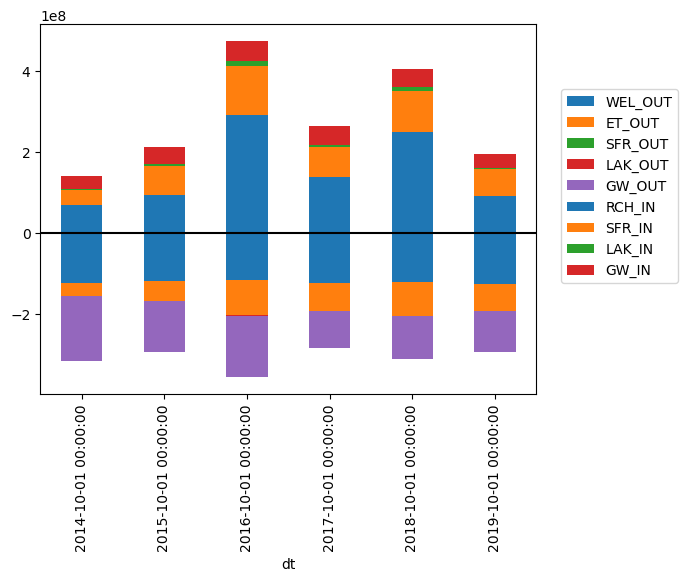

In [152]:
wb_ann = wb.resample('AS-Oct').sum(numeric_only=True)
fig,ax = plt.subplots( sharex=True)
plt.axhline(0, color='black')
wb_ann[out_cols].multiply(-1).plot( kind='bar', ax=ax, stacked=True)
wb_ann[in_cols].plot( kind='bar', ax=ax, stacked=True)
plt.legend(loc=(1.05,0.3))

Text(0, 0.5, 'Outflow\n($10^6 m^3/day$)')

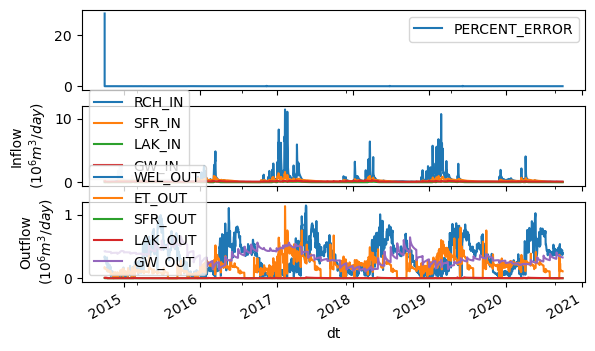

In [153]:
fig,ax = plt.subplots(3,1, figsize=(6.5,4), sharex=True)
wb.plot(y='PERCENT_ERROR', ax=ax[0])
wb[in_cols].multiply(1E-6).plot(y=in_cols, ax=ax[1], legend=True)
wb[out_cols].multiply(1E-6).plot(y=out_cols, ax=ax[2], legend=True)

ax[1].set_ylabel('Inflow\n($10^6 m^3/day$)')
ax[2].set_ylabel('Outflow\n($10^6 m^3/day$)')

# ax[1].set_ylim(0,1E3)
# ax[2].set_ylim(0,1E5)

Text(0.5, 0, 'Date')

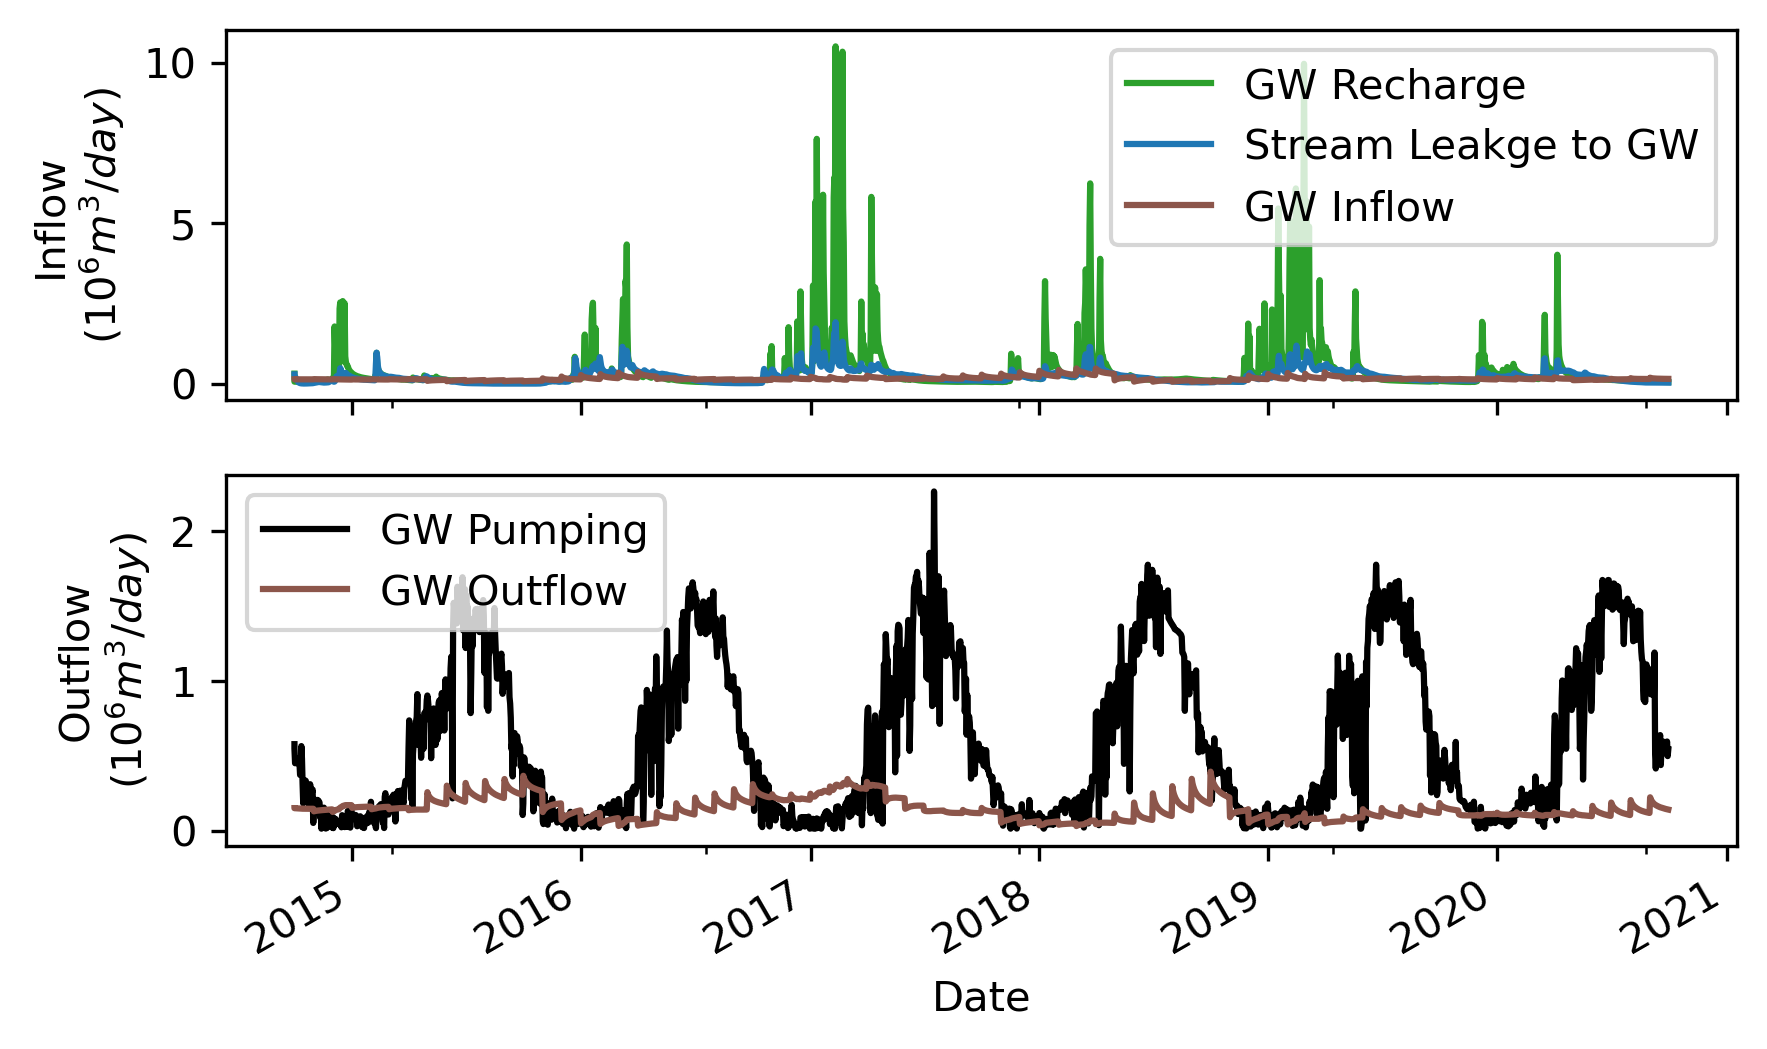

In [18]:

fig,ax= plt.subplots(2,1, figsize=(6.5, 4), sharex=True, dpi=300)
# in_labels = ['Foothills GW Inflow','Boundary GW Inflow','GW Recharge', 'Stream Leakge to GW']
# wb[in_cols].multiply(1E-6).plot(y=in_cols, ax=ax[0], legend=True, label=in_labels)
# out_labels = ['Foothills GW Outflow','GW Pumping','Boundary GW Outflow','GW Leakage to Streams']
# wb[out_cols].multiply(1E-6).plot(y=out_cols, ax=ax[1], legend=True, label=out_labels)

in_labels = ['GW Recharge', 'Stream Leakge to GW','GW Inflow']
wb[in_cols].multiply(1E-6).plot(y=['RCH_IN','SFR_IN', 'GW_IN'], ax=ax[0], legend=True, 
                                label=in_labels, color=['tab:green','tab:blue','tab:brown'])
out_labels = ['GW Pumping','GW Outflow']
wb[out_cols].multiply(1E-6).plot(y=['WEL_OUT','GW_OUT'], ax=ax[1], legend=True, 
                                 label=out_labels, color=['black','tab:brown'])

ax[0].set_ylabel('Inflow\n($10^6 m^3/day$)')
ax[1].set_ylabel('Outflow\n($10^6 m^3/day$)')
plt.xlabel('Date')
# plt.savefig(join(plt_dir, 'total_water_budget_time_series.png'),  bbox_inches='tight')


In [677]:
# hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
# plt.contour(hdobj.get_data((0,0))[-1])
# plt.colorbar()

# Sim vs Obs Head


In [154]:
# model_ws = loadpth+'historical_simple_geology'
model_ws = loadpth+'historical_simple_geology_reconnection'


In [155]:
hobout = pd.read_csv(model_ws+'/MF.hob.out',delimiter=r'\s+', header = 0,names = ['sim_val','WSE','obs_nam'],
                     dtype = {'sim_val':float,'obs_val':float,'obs_nam':object},
                    na_values=[-9999.])
# if only one obs exists correct naming convention
one_obs = ~hobout.obs_nam.str.contains('.0')
hobout.loc[one_obs,'obs_nam'] = hobout.loc[one_obs,'obs_nam']+'.'+str(1).zfill(5)

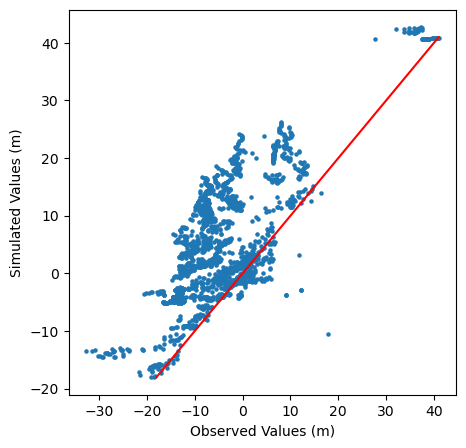

In [156]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

# get boundary values for plotting a 1:1
hobmax = hobout.loc[:,['sim_val','WSE']].max().min()
hobmin = hobout.loc[:,['sim_val','WSE']].min().max()

# plot observed vs simulated values
hobout.plot.scatter(x='WSE', y='sim_val',marker='.',ax=ax)
ax.plot([hobmin,hobmax],[hobmin,hobmax],'red')
ax.set_xlabel('Observed Values (m)')
ax.set_ylabel('Simulated Values (m)')
# plt.xlabel('Observed Values (m)')
# plt.ylabel('Simulated Values (m)')

# lim2 = hobout.loc[:,['WSE']].max().min()
# lim1 = hobout.loc[:,['WSE']].min().max()
# ax.set_ylim(lim1,lim2)

fig_nam = plt_dir+'GSP_WaterBudget/sim_vs_obs_heads'

# plt.savefig(fig_nam+'.png',dpi=600,bbox_inches='tight')
# plt.savefig(fig_nam+'.svg',dpi=600,bbox_inches='tight')

In [107]:
def mak_hob_gpd(hobout):
    all_obs = pd.read_csv(model_ws+'/input_data/all_obs_grid_prepared.csv',index_col=0)
    all_obs.index = all_obs.index.rename('date')
    all_obs = all_obs.reset_index()
    # join more indepth obs data to output simulated heads
    obs_data = hobout.join(all_obs.set_index('obs_nam'),on=['obs_nam'], how='right')
    obs_data = obs_data.dropna(subset=['node'])
#     obs_data.loc[:,['row','column','node']] = obs_data.loc[:,['row','column','node']].astype(int)
    obs_data[['row','column','node']] = obs_data[['row','column','node']].astype(int)
    # add hk to plot unit
    obs_data['hk'] = gel.hk.array[obs_data.layer-1, obs_data.row-1, obs_data.column-1]
    # obs_data.index = obs_data.index
    obs_grid = obs_data.join(grid_p.set_index(['row','column']).loc[:,['easting','northing']], 
                             on=['row','column'])
    # # convert back to geospatial
    hob_gpd = gpd.GeoDataFrame(obs_grid, geometry = gpd.points_from_xy(obs_grid.easting, obs_grid.northing),
                              crs = grid_p.crs)
    hob_gpd['error'] = hob_gpd.WSE - hob_gpd.sim_val
    hob_gpd['abs_error'] = hob_gpd.error.abs()
    
    if 'date' in hob_gpd.columns:
        hob_gpd = hob_gpd.set_index('date')
        hob_gpd.index = pd.to_datetime(hob_gpd.index)    
        #     groupby values by season
        hob_gpd.loc[(hob_gpd.index.month > 2)&(hob_gpd.index.month < 6),'season'] = 'spring'
        hob_gpd.loc[(hob_gpd.index.month > 8)&(hob_gpd.index.month < 12),'season'] = 'fall'
    
    return(hob_gpd)
    # set date
    


In [157]:
hob_gpd = mak_hob_gpd(hobout)

hob_seasonal = hob_gpd.groupby(['node','season']).mean(numeric_only=True)
hob_seasonal = gpd.GeoDataFrame(hob_seasonal, geometry = gpd.points_from_xy(hob_seasonal.easting, hob_seasonal.northing))
hob_seasonal = hob_seasonal.reset_index()
    


In [158]:
stns = hob_gpd.drop_duplicates('site_code', keep='last').reset_index().drop(columns=['date','gwe'])
stns['botm_elev'] = m.dis.botm[stns.layer-1, stns.row-1, stns.column-1]
stns.crs = hob_gpd.crs

In [159]:
hob_gpd['Statistic'] = 0.01
hob_gpd['StatFlag'] = 'SD'
# locations with significant difference between RPE GSE and the DEM should have additional uncertainty included
hob_gpd['Statistic'] += np.round(np.abs(hob_gpd.dem_wlm_gse),4)
hob_gpd['Weight'] = 1/(hob_gpd.Statistic**2)

soswr = (np.sum(np.abs(hob_gpd.sim_val-hob_gpd.WSE)*hob_gpd.Weight))
print('Sum of absolute difference of OBS and SIM: %.2e' %soswr)

Sum of absolute difference of OBS and SIM: 4.81e+05


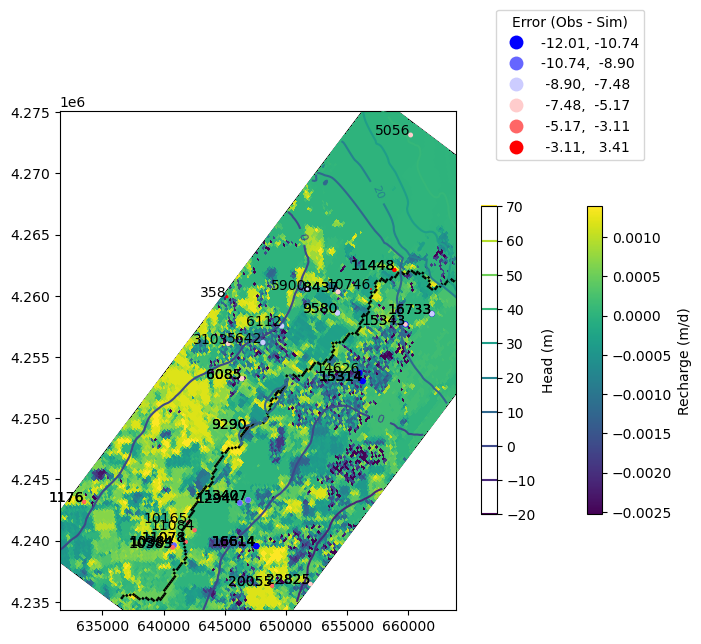

In [137]:
def plt_hob_map(y, s, nd_chk=None):
    fig,ax=plt.subplots(figsize=(8, 8))
    m_domain.plot(ax=ax,color='None')
    mapview = flopy.plot.PlotMapView(model=m,ax=ax)
#     csa = mapview.plot_array(gel.hk.array[1,:,:], norm=mpl.colors.LogNorm())
#     cb = plt.colorbar(csa, shrink=0.5,ax=ax)
#     cb.set_label('Horiz. Cond. (m/d)')

#     csa = mapview.plot_array(-pump_rate.mean(axis=0), vmin=-np.quantile(pump_rate, .95))
    csa = mapview.plot_array(rech.mean(axis=0)- pump_rate.mean(axis=0), vmin=-np.quantile(pump_rate, .95))
    cb = plt.colorbar(csa, shrink=0.5,ax=ax)
    cb.set_label('Recharge (m/d)')

    hob_gpd_plt = hob_gpd[(hob_gpd.index.year==y)&(hob_gpd.season==s)]

    if nd_chk != None:
        hob_gpd_plt = hob_gpd_plt[hob_gpd_plt.node.isin(nd_chk)]
    # hob_gpd.plot('error',scheme='EqualInterval', k= 6, ax=ax,legend=True,cmap='magma')
    hob_gpd_plt.plot('error',markersize='abs_error',scheme='Quantiles', k = 6, ax=ax,
                      legend=True,cmap='bwr',legend_kwds={'loc':(1.1,0.9),'title':'Error (Obs - Sim)'})
    hob_gpd_plt.apply(lambda x: ax.annotate(str(x.node), xy=(x.geometry.x, x.geometry.y), ha='right'),axis=1);
    # stns[stns.botm_elev > stns.screen_elev].plot(color='red',marker='x',ax=ax)
    grid_sfr.plot(ax=ax,color='black')
    contour_set = mapview.contour_array(hdobj.get_data((0,int(hob_gpd_plt.spd.mean()))),
                                masked_values=[-999.99],  ax=ax)
    hcb = plt.colorbar(contour_set, shrink = 0.5,ax=ax)
    hcb.set_label('Head (m)')
    ax.clabel(contour_set, contour_set.levels[0::2], inline=True, fontsize=8)
#     foothills.plot(ax=ax, alpha=0.5, edgecolor='black', color='grey')
    
    gdf_bnds(hob_gpd_plt, ax=ax, buf=2E3)
    return(hob_gpd_plt)

    # ax.legend(loc=(1,0.5))
hob_gpd_plt = plt_hob_map(2019, 'fall')

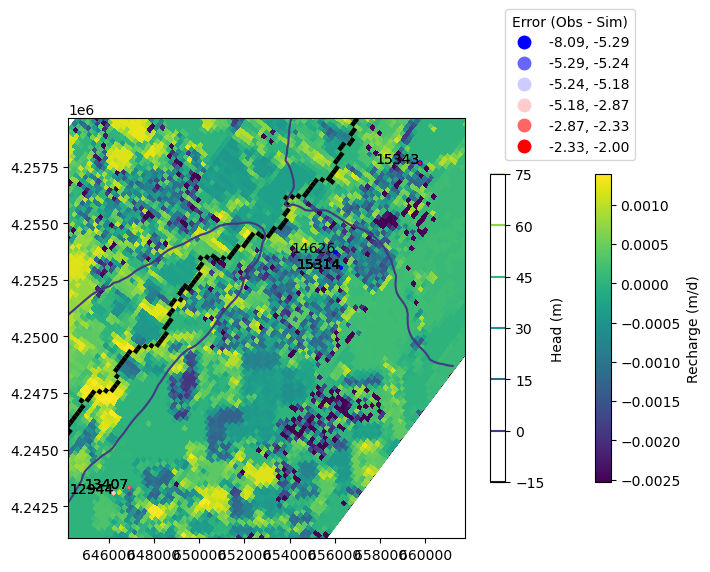

In [178]:
nd_chk = [15343, 16733, 11448, 8437, 15314, 14626] +[3103, 5642, 6112, 10746, 6458]
# nd_chk = [2926, 8437, 12944, 13407]
nd_chk = [15314, 15343, 13407, 12944, 14626]
hob_gpd_chk = plt_hob_map(2019, 'fall', nd_chk=nd_chk)


In [124]:
df_chk = hob_gpd_chk.groupby('node').mean(numeric_only=True)
df_chk['rech'] = rech.sum(axis=0)[df_chk.row.astype(int)-1, df_chk.column.astype(int)-1]
df_chk[['sim_val','WSE','avg_screen_depth', 'hk', 'rech', 'layer','abs_error']]

,sim_val,WSE,avg_screen_depth,hk,rech,layer,abs_error
node,,,,,,,
3103,-2.404732,-7.991900,81.07680,48.951000,1.692249,17.0,5.587168
5642,0.601442,-7.168900,60.80760,21.951000,0.987455,11.0,7.770342
6112,0.138765,-8.571000,86.86800,0.561600,2.386058,15.0,8.709765
8437,3.876604,-1.473200,0.00000,69.075928,1.007960,1.0,5.349804
10746,7.847272,7.602000,90.92184,113.470200,1.364777,16.0,0.245272
11448,9.363730,12.588233,39.09060,48.951000,2.578314,3.0,3.224503
14626,3.556347,-8.458200,47.70120,0.561600,1.472325,5.0,12.014547
15314,2.832205,-7.865737,80.16240,0.561600,0.798554,11.0,10.697943
15343,10.524361,1.652050,44.04360,32.821201,1.245299,2.0,8.872311


In [172]:

hobout = pd.read_csv(model_ws+'/MF.hob.out',delimiter=r'\s+', header = 0,names = ['sim_val','WSE','obs_nam'],
                     dtype = {'sim_val':float,'obs_val':float,'obs_nam':object},
                    na_values=[-9999.])
# if only one obs exists correct naming convention
one_obs = ~hobout.obs_nam.str.contains('.0')
hobout.loc[one_obs,'obs_nam'] = hobout.loc[one_obs,'obs_nam']+'.'+str(1).zfill(5)

hob_gpd = mak_hob_gpd(hobout)

# find sites with long time series of OBS
hobs_long = (hob_gpd.groupby('site_code').count()>=int(m.dis.nper/365)*2)
hobs_long = hobs_long.index[hobs_long.WSE].values
# hobs_long.shape


In [173]:
# get layer, row, column for extracting time series head data
# hob_kij = hob_gpd.drop_duplicates('node')[['node','layer','row','column']]
# hob_kij[['layer','row','column']] -=1
# hob_kij['kij'] = list(hob_kij[['layer','row','column']].astype(int).itertuples(index=False,name=None)) #hob_ts

# load times series to check if making changes to hob layer
# hob_ts = pd.DataFrame(hdobj.get_ts(hob_kij.kij.tolist()),columns=np.append(['spd'],hob_kij.node.values)) 
# hob_ts['date'] = strt_date+hob_ts.spd.astype('timedelta64[D]')
# hob_ts = hob_ts.drop(columns='spd')
# ts_long = hob_ts.melt(id_vars='date', var_name='node',value_name='sim_new')
# ts_long.node = ts_long.node.astype(int)
# hob_ts_chk = hob_gpd.join(ts_long.set_index(['date','node']), on=['date','node'],how='left')

In [174]:
# hob_gpd.site_code.unique().shape, voi.shape
# hob_long = hob_gpd[hob_gpd.site_code.isin(hobs_long)]
# hob_long = hob_ts_chk.melt(value_vars=['sim_val','WSE', 'sim_new'], id_vars=['node'], ignore_index=False)
hob_long = hob_gpd.melt(value_vars=['sim_val','WSE'], id_vars=['node'], ignore_index=False)


In [175]:
hob_long.index.max()

Timestamp('2020-09-25 00:00:00')

In [176]:
well_ref = hob_gpd.drop_duplicates('site_code')[['site_code','node']].sort_values('node')
well_ref[well_ref.site_code.str.contains("MW")]

,site_code,node
date,,
2016-02-01,MW_DR1,9290
2014-12-01,MW_9,10161
2014-11-01,MW_5,10165
2014-12-01,MW_22,10383
2018-02-01,MW_Rooney 1,10746
2014-12-01,MW_19,11078
2014-11-01,MW_11,11084


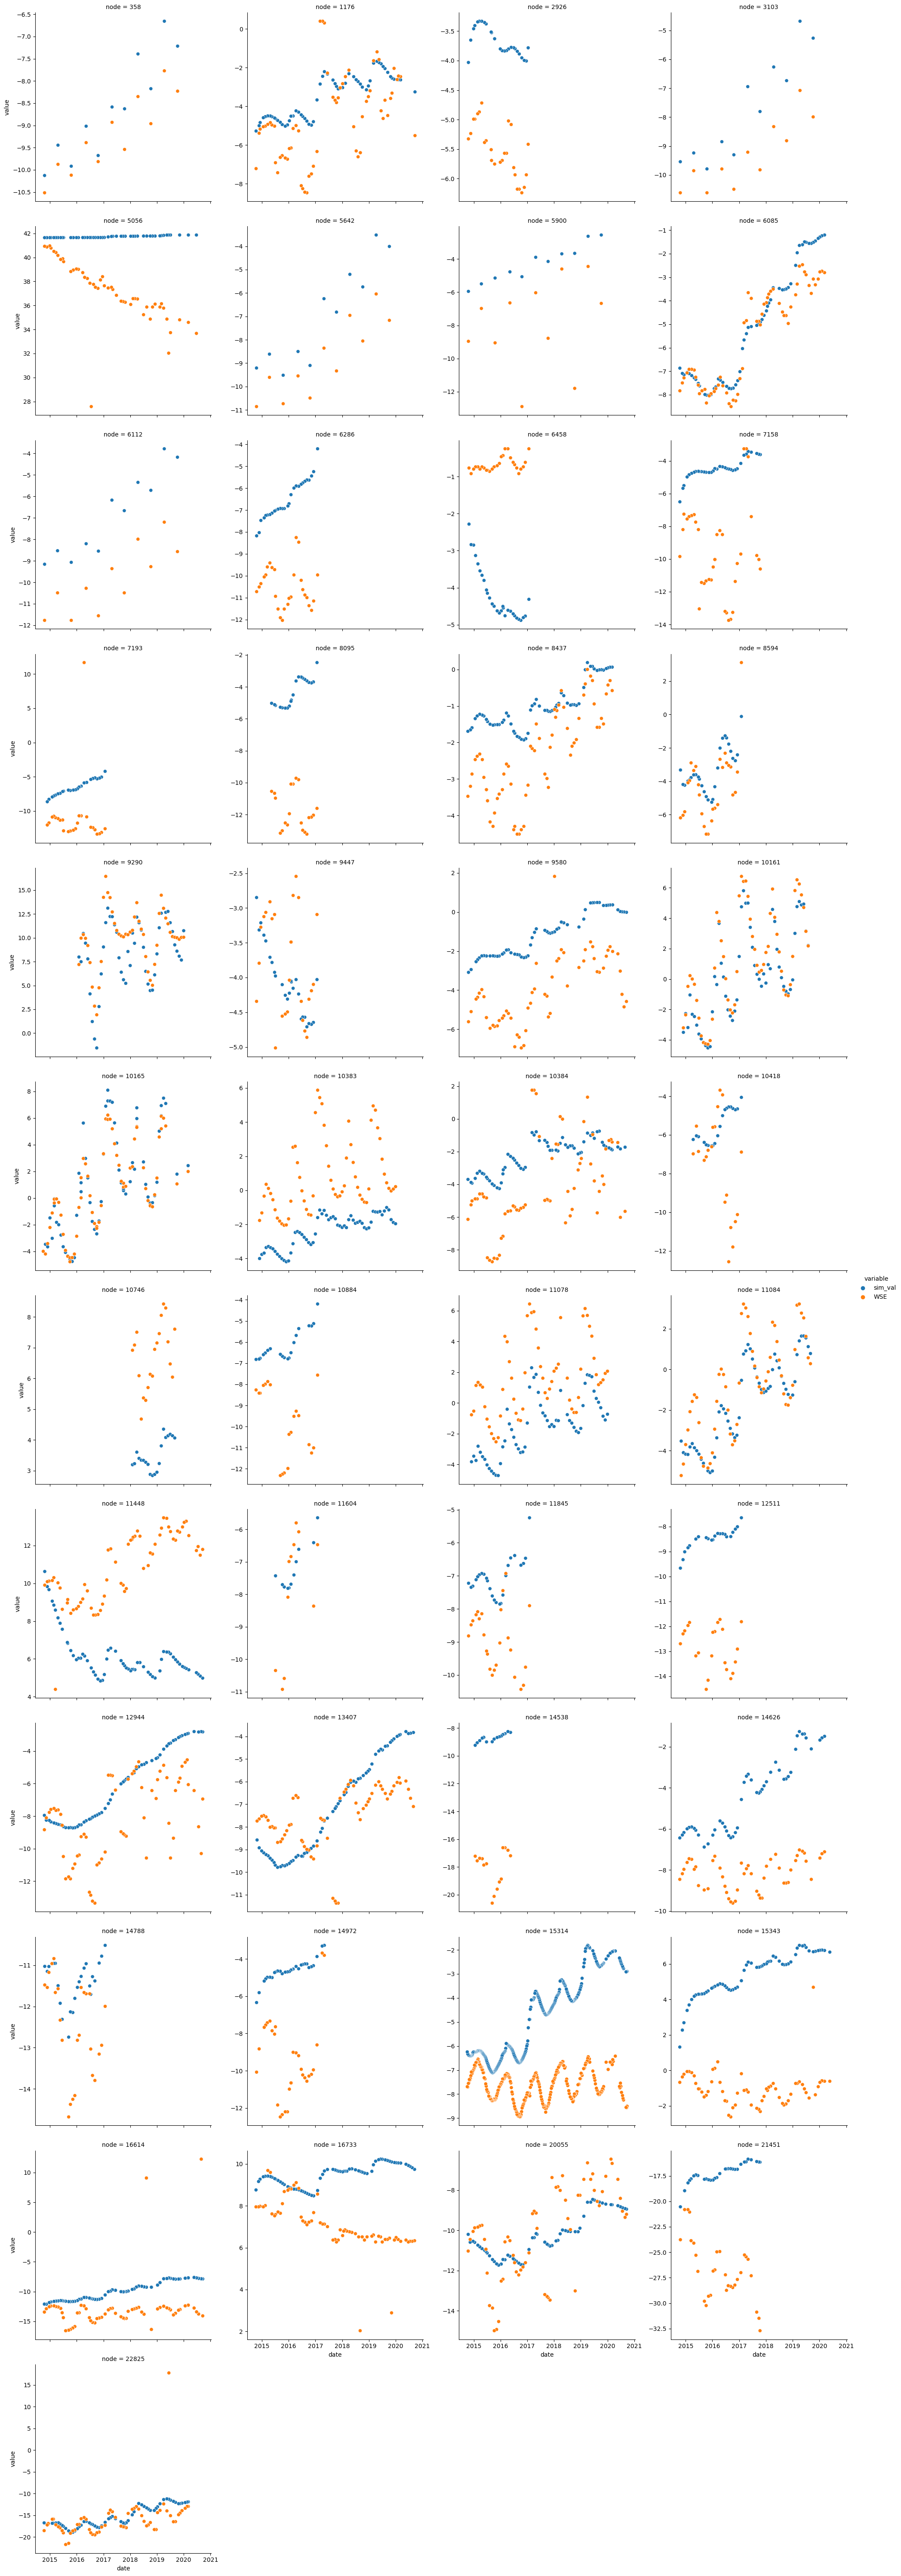

In [177]:
# chk_lng = hob_long.groupby('node').count().variable
# chk_lng = chk_lng[chk_lng>50].index
# sns.relplot(hob_long[hob_long.node.isin(chk_lng)], x='date',y='value', 
sns.relplot(hob_long, x='date',y='value', 
            hue='variable',  col='node',
#             col_wrap=10, # for powerpoint
            col_wrap=4,
           facet_kws={'sharex':True, 'sharey':False})

In [688]:

# voi = hob_gpd[hob_gpd.site_code.isin(hobs_long)].node.unique()
# # voi = 22825
# # def obs_sim_node(voi):
# ny = 3
# nx = int(np.ceil(len(voi)/ny))
# fig,ax=plt.subplots(nx,ny,figsize=(12,3*nx))
# for i,voi_n in enumerate(voi):
#     ax_n = ax[int(i / ny), i % ny] if (nx > 1) else ax[i]
#     hob_n = hob_gpd[hob_gpd.node==voi_n]
#     hob_n.reset_index().plot(x='date',y='WSE',kind='scatter', ax=ax_n,
#                                                   marker='x', s=40, legend=False)
#     hob_n.reset_index().plot(x='date',y='sim_val',kind='scatter', ax=ax_n, 
#                                                   marker='o', s=40, legend=False)
#     # add time series of simulated data to see true peaks
# #     ts_i = pd.DataFrame(hdobj.get_ts(hob_kij[hob_kij.node==voi_n].kij.values[0]),columns=['spd','sim_val']) 
#     ts_i['dt'] = dt_ref.dt
#     ts_i.plot(x='dt',y='sim_val', ax=ax_n, legend=False)

#     ax_n.set_xlabel('')
#     ax_n.set_ylabel('')
#     S_n = format(gel.ss.array[hob_n.layer.iloc[0],hob_n.row.iloc[0],hob_n.column.iloc[0]],'.1e')
#     K_n = format(gel.hk.array[hob_n.layer.iloc[0],hob_n.row.iloc[0],hob_n.column.iloc[0]], '.1e')

#     ax_n.set_title(str(voi_n)+' K'+K_n+' S'+S_n+'\n'+hob_n.site_code.iloc[0])
# ax_n.legend(['Observed','Simulated'])
# ax[0,0].legend(['Observed','Simulated'])

# # fig.text(-0.03, 0.2, 'Head (m)',rotation='vertical',size=26)
# # fig.text(0.35, -0.05, 'Date',size=26)
# fig.tight_layout()


In [69]:
ghb_dir = join(gwfm_dir, 'GHB_data')
year = strt_date.year # 2016
filename = glob.glob(ghb_dir+'/final_WSEL_arrays/spring'+str(year)+'_kriged_WSEL.tsv')[0]
# convert from ft to meters
hd_strt = np.loadtxt(filename)*0.3048

In [85]:
model_ws

'F://WRDAPP/GWFlowModel/Cosumnes/Regional/historical_simple_geology'

Text(0, 0.5, 'Elevation (m)')

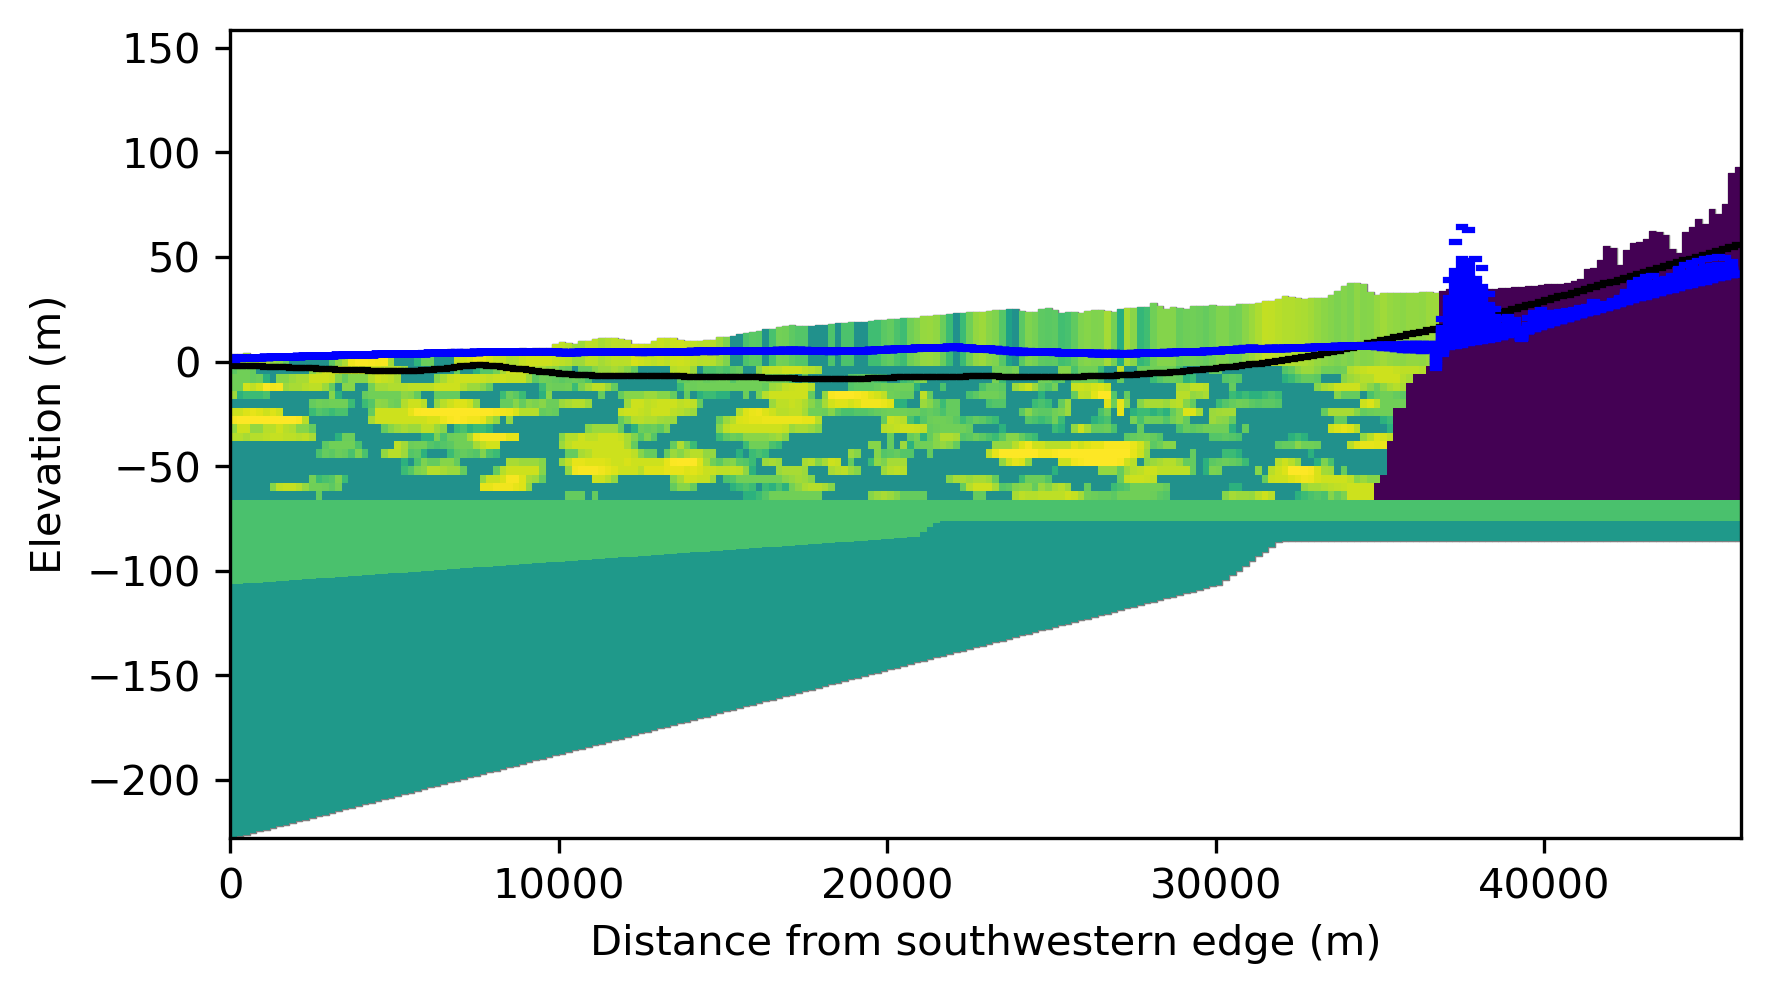

In [100]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
fig, ax = plt.subplots(figsize=(6.5, 3.5), dpi=300) # was 40, 20 before

plt.aspect=10

head = hdobj.get_data(kstpkper = spd_stp[0])
# head_new = hdobj.get_data(kstpkper = spd_stp[1400])

rownum = 50
# rownum = 0

mcs = flopy.plot.PlotCrossSection(model=m, line={'Row' : rownum})
# colnum = 150
# mcs = flopy.plot.PlotCrossSection(model=m, line={'Column' : colnum})

linecollection = mcs.plot_grid(linewidth = 0.3)
ax.add_collection(linecollection)

mcs.plot_array(a=gel.hk.array, norm = mpl.colors.LogNorm())

wt = mcs.plot_surface(a=hd_strt[:,:], color='black')
wt = mcs.plot_surface(a=head[:,:,:], color='blue')
# wt = mcs.plot_surface(a=head_new[:,:,:],color='red')

plt.xlabel('Distance from southwestern edge (m)')
plt.ylabel('Elevation (m)')

In [666]:
m.dis.nlay

7

In [528]:
head_new[-1,50,173], head_new[-1,50,200], head_new[-1,50,229]

(25.101976, 22.880537, 42.0)

In [530]:
head_new[-1,50,175::5]

array([24.571903, 17.591667, 15.547163, 19.676798, 22.68533 , 26.167103,
       30.770975, 35.173237, 38.69047 , 41.132378, 42.250614],
      dtype=float32)

In [522]:
hob_gpd_chk[hob_gpd_chk.node==16733].column

date
2019-11-07    173
2019-10-10    173
2019-09-12    173
Name: column, dtype: int32

# Plot stream water budget

In [562]:
vka = gel.vka.array
sfrdf = pd.DataFrame(m.sfr.reach_data)
grid_sfr = grid_p.set_index(['row','column']).loc[list(zip(sfrdf.i+1,sfrdf.j+1))].reset_index(drop=True)
grid_sfr = pd.concat((grid_sfr,sfrdf),axis=1)
# group sfrdf by vka quantiles
# sfr_vka = vka[grid_sfr.k, grid_sfr.i, grid_sfr.j]
# for p in vka_quants.index:
#     facies = vka_quants.loc[p]
#     grid_sfr.loc[(sfr_vka< facies.vka_max)&(sfr_vka>= facies.vka_min),'facies'] = facies.facies
#     # add color for facies plots
# grid_sfr = grid_sfr.join(gel_color.set_index('geology')[['color']], on='facies')

In [563]:
# grid_sfr = pd.DataFrame().from_records(m.sfr.reach_data).rename(columns={'i':'row','j':'column'})
# grid_sfr[['row','column']] += 1 # convert to 1 based to match with SFR output
# pd_sfr = grid_sfr.set_index(['iseg','ireach'])[['rchlen','strtop', 'facies']]
# pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()

def clean_sfr_df(model_ws, pd_sfr=None):
    sfrout = flopy.utils.SfrFile(join(model_ws, m.name+'.sfr.out'))
    sfrdf = sfrout.get_dataframe()
    sfrdf = sfrdf.join(dt_ref.set_index('kstpkper'), on='kstpkper').set_index('dt')
    # convert from sub-daily to daily using mean, lose kstpkper
    sfrdf = sfrdf.groupby(['segment','reach']).resample('D').mean(numeric_only=True)
    sfrdf = sfrdf.reset_index(['segment','reach'], drop=True)
    sfrdf[['row','column']]-=1 # convert to python
    sfrdf['month'] = sfrdf.index.month
    sfrdf['WY'] = sfrdf.index.year
    sfrdf.loc[sfrdf.month>=10, 'WY'] +=1
    # add column to track days with flow
    sfrdf['flowing'] = 1
    sfrdf.loc[sfrdf.Qout <= 0, 'flowing'] = 0
    if pd_sfr is not None:
    #     sfrdf = pd_sfr.join(sfrdf.set_index(['row','column']),on=['row','column'],how='inner',lsuffix='_all')
        sfrdf = sfrdf.join(pd_sfr ,on=['segment','reach'],how='inner',lsuffix='_all')

    # create different column for stream losing vs gaining seeapge
    sfrdf['Qrech'] = np.where(sfrdf.Qaquifer>0, sfrdf.Qaquifer,0)
    sfrdf['Qbase'] = np.where(sfrdf.Qaquifer<0, sfrdf.Qaquifer*-1,0 )
    # booleans for plotting
    sfrdf['gaining'] = (sfrdf.gradient == 0)
    sfrdf['losing'] = (sfrdf.gradient >= 0)
    sfrdf['connected'] = (sfrdf.gradient < 1)
    return(sfrdf)



In [564]:
sfrdf = clean_sfr_df(model_ws)

In [565]:
sfr_sum = sfrdf.groupby(['segment','reach','row','column','layer']).mean().reset_index()
# sfr_seg_sum = sfrdf.groupby(['segment']).mean().reset_index()

,0,geometry
0,0,"MULTIPOLYGON (((662923.964 4258534.289, 662919..."


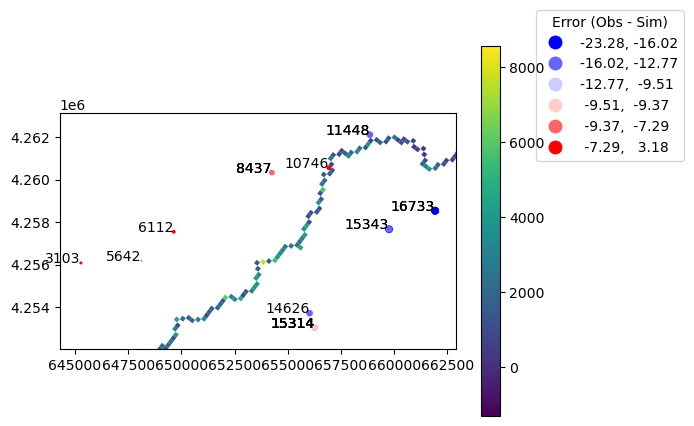

In [369]:
fig,ax = plt.subplots()
# grid_p.merge(sfr_sum, on=['row','column']).plot('Qin', legend=True)
grid_p.merge(sfr_sum, on=['row','column']).plot('Qaquifer', legend=True, ax=ax)
# hob_gpd_chk.plot('Error', ax=ax, legend=True)
hob_gpd_chk.plot('error',markersize='abs_error',scheme='Quantiles', k = 6, ax=ax,
                  legend=True,cmap='bwr',legend_kwds={'loc':(1.2,0.8),'title':'Error (Obs - Sim)'})
hob_gpd_chk.apply(lambda x: ax.annotate(str(x.node), xy=(x.geometry.x, x.geometry.y), ha='right'),axis=1);
gdf_bnds(hob_gpd_chk, ax=ax, buf = 1E3)